In [3]:
# import the two phase simplex solver
from two_phase_simplex_unmodified import TwoPhaseSimplex
import numpy as np

# Designing the damage maximisation linear program
maximise $f(x)$ <br>
subject to: <br>
skill level cannot be below 0 or above 99 <br>
skill level should at minimum be the skill req of the weapon OR the class minimum <br>
the sum of all skill levels should be equal to the level of the player plus the sum of all initial skill levels <br> <br>
This directly translates to the following mathematically:<br>
 -min $-f(x)$ <br>
subject to: <br>
$\text{max}(r_i, k_i) \leq x_i \leq 99, \forall i \in D$ <br>
Where $D$ is the set of all damage inducing skills, $k_i$ is the class minimum points of skill $i$ and $r_i$ is the minimum point requirement for skill $i$ for the given weapon.

<br> <br>
In standard form for a linear program: <br>
-min $-f(x)$<br>
subject to: <br>
$x_i + s_i = 99, \forall i \in D$ <br>
$x_i - t_i = \text{max}(r_i, k_i), \forall i \in D$<br>
$\sum_{i \in D} x_i = l_0 + \sum_{i \in D} k_i$ <br>
$x_i,s_i,t_i \in  Z^+ = \set{0,1,2,3,...}$ <br> <br>

This should be rewritten to the matrix form:
-min $-f(x)$<br>
subject to: <br>
$Ax=b$ \
$x\in  Z^+ = \set{0,1,2,3,...}$ <br> <br>


This allows us to directly solve the problem using the two phase simplex method.

# Writing the prescribed problem

### Finding an expression for the damage function $f(x)$

In [12]:
def get_scales_list(scalings : list) -> list:
    """Gets the list of float damage scales for the weapon given"""
    scalings_copy = scalings.copy()
    # translate scalings to floats
    scaling_dict = {"S" : 1.7, "A" : 1.195, "B" : 0.87, "C": 0.62, "D" : 0.37, "E" : 0.125, "F" : 0}
    for i, letter_scale in enumerate(scalings):
        scalings_copy[i] = scaling_dict[letter_scale]
    return scalings_copy

def rating_physical(x : int) -> float:
    """piecewise continous linear function depicting the physical rating of a character"""
    if x <= 10:
        return 0.005*x
    elif x <= 20:
        return 0.05 + 0.035*(x-10)
    elif x <= 50:
        return 0.4 + 0.0225*(x-20)
    else:
        return 0.85 + 0.0025*(x-40)
    
def rating_magic(x : int) -> float:
    """piecewise continous linear function depicting the magic rating of a character"""
    if x <= 10:
        return 0.005*x
    elif x <= 30:
        return 0.05 + 0.0225*(x-10)
    elif x <= 50:
        return 0.5 + 0.015*(x-30)
    else:
        return 0.8 + 0.0041*(x-50)
    
def get_rating(i : int, x : int) -> float:
    """
    Gets the rating of skill i dependant on its skill level x.
    """
    assert i >= 0 and i < 4 # assert that the skill is in the accepted range
    if (i < 2):
        return rating_physical(x)
    return rating_magic(x)
    
def get_ratings_list(points : list) -> list:
    ratings_copy = points.copy()
    for i, point in enumerate(points):
        ratings_copy[i] = get_rating(i, point)
    return ratings_copy

def get_total_damage_rating(points : list, scalings : list, weapon : list, two_handing : bool = False):
    """
    The total attack rating of the dark souls game engine,
    points = x = [STR, DEX, INT, FAITH] (skill points)
    scalings = [STR, DEX, INT, FAITH] (letter scaling of skills)
    weapon = [base_physical, base_magic]
    Note that only points is variate and all other inputs are constants
    """
    # two handing a weapon causes a 1.5x increase in strength skill
    if (two_handing):
        points[0] *= 1.5
    # translate letter scales to float multipliers
    scalings = np.array(get_scales_list(scalings))
    # get damage ratings for all skills dependant on points
    ratings = np.array(get_ratings_list(points))
    # reassign weapon to be a np array for vector operations
    weapon : np.ndarray = np.array(weapon)
    decision_variates : np.ndarray = np.zeros(2)
    # multiplying two np arrays results in an entry wise multiplication
    print(scalings[0])
    decision_variates[0] = 1+sum(ratings[0:2]*scalings[0:2])
    decision_variates[1] = 1+sum(ratings[2:4]*scalings[2:4])
    # now dot product of weapon and decision_variates
    total_damage_rating = np.dot(weapon, decision_variates)
    return total_damage_rating


### Writing down the constaint matrix A

In [17]:
def get_constraint_matrix(class_skills : list) -> np.ndarray:
    """
    Returns the matrix representing the constraints of the damage maximisation problem
    class_skills = [STR, DEX, INT, FAITH]
    """
    # constraint 1
    A : np.ndarray = np.zeros((9,12)) # 9 * 12 matrix
    # maximum level is 99, rows 0 to 3
    for i in range(len(class_skills)):
        A[i, i] = A[i,i+4] = 1
    # minimum level is max of class_skills[i] and weapon_requirements[i], rows 4 to 7
    for i in range(len(class_skills)):
        A[i + 4, i] = 1 
        A[i+4,i+8] = -1
    A[8][0:4] = np.ones(4)
    return A

### Writing down the vector $b$

In [19]:
def get_b_vector(class_skills : list, weapon_requirements : list, levels : int) -> np.ndarray:
    """
    Returns the vector b from the matrix form of the linear program for the weapon maximisation
    """
    b : np.ndarray = np.zeros(9)
    b[0:4] = 99
    for i in range(4):
        b[i+4] = max(class_skills[i], weapon_requirements[i])
    b[8] = levels + sum(class_skills)
    return b

# Problem in using the unmodified simplex method

The two phase simplex method depends on the fact that the original objective function has a constant coefficient form in front of each decision variable. <br>
However here the objective function $f(x)$ has coefficients that will obviously depend due to the "rating" variable in the total attack rating.

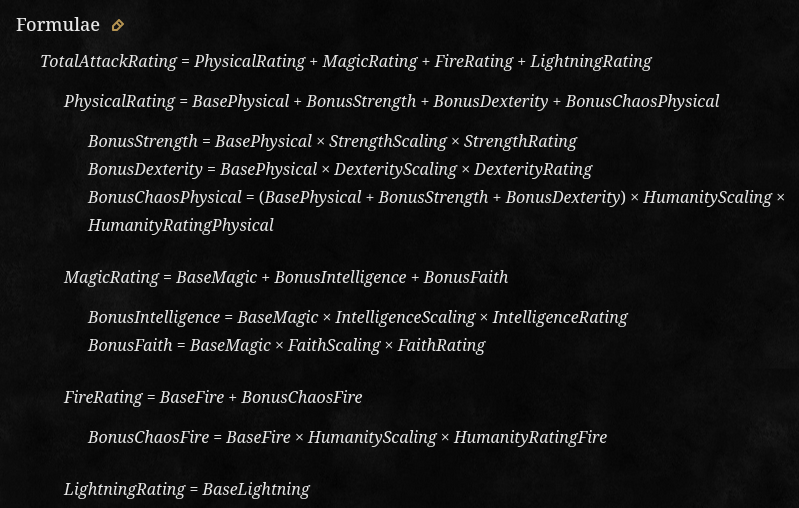

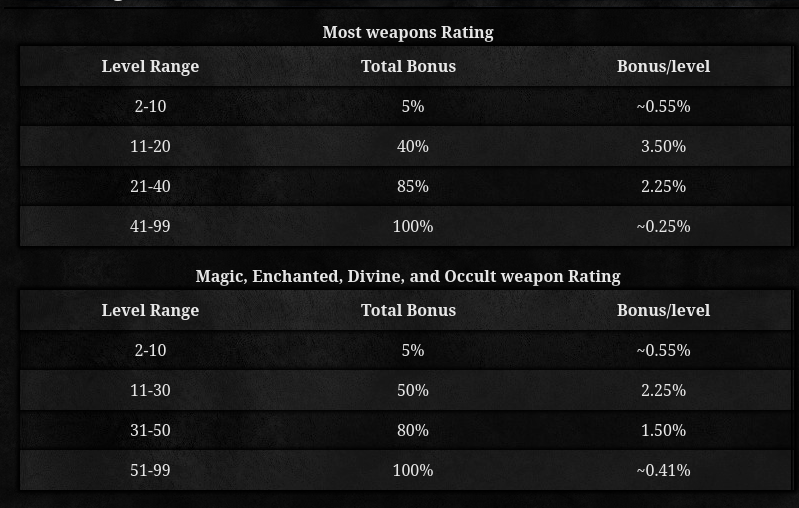

Here we see as our decision variables cross certain intervals on which they exist then there will be a change in the "constant" variables.

## Tackling this issue - Overviews of solution

### Approximation of $f(x)$

We can simply approximate $f(x)$ in the form $c\cdot x$ where c is a constant vector deciding how important each skill is, however this will only approximate a solution to the optimization problem as we will no longer be tracking the exact damage like seen in $f(x)$.

### Change the simplex phase 2

It may be possible to derive a non-constant objective function variation of the phase 2 simplex to solve this issue

### Apply phase 1 algorithm iteratively on interval crosses

Alternatively, we can treat the function as constant until our decision variables $x_1,...,x_4$ cross these intervals.<br>
The intervals being $[1,10],[11,20],[21,40],[41,99]$ for physical decision variables $x_1,x_2$ and $[1,10],[11,30],[31,50],[51,99]$ for the magic decision variables $x_3,x_4$. <br>

This is probably the easiest way to accomplish an exact solution, however this means we have to run the simplex method up to $4^4=256$ times per damage optimization (if every variable crosses every interval in one runtime), need to consider how we will deal with terminating the simplex method per change of objective function.